In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Carga del dataset

Utilizando spark se realizo una partición del 2.5% de los datos del dataset original.

In [2]:
with open("header.txt", "r") as f:
    line = f.readline()
    cols = line.split(",")
    
df = pd.read_csv("data_sample.csv", header = None, sep = ",", names = cols)
df.head()

,periodo,id_cli,fecha_nacimiento,edad,genero,estado_civil,nivel_academico,profesion,ocupacion,tipo_vivienda,...,cuota_libranza_sf,cant_oblig_tot_sf,cant_cast_ult_12m_sr,ind,rep_calif_cred,pol_centr_ext,convenio_lib,ingreso_nomina,ingreso_segurida_social,gasto_familiar
0,202003,2089776,19840630,35.638604,M,DIVORCIADO,TECNOLOGO,TECNOLOGIA SISTEMAS,Empleado,ALQUILADA,...,0.0,0.0,0.0,695516.000,C,0.0,\N,1255032.0,NaN,304687.00
1,201902,2088089,19860727,32.476386,M,UNION LIBRE,NO INFORMA,\N,Independiente,FAMILIAR,...,0.0,NaN,NaN,1187025.000,SIN INFO,NaN,\N,NaN,NaN,187990.00
2,202001,3892351,19910108,28.936345,M,SOLTERO,TECNOLOGO,OTROS,Independiente,\N,...,0.0,NaN,NaN,3879251.250,SIN INFO,NaN,\N,NaN,NaN,862348.92
3,202008,2897552,19900903,29.883641,M,SOLTERO,BACHILLER,\N,Empleado,\N,...,0.0,0.0,1.0,210681.475,F,7.0,\N,NaN,1484205.0,1056864.00
4,202001,4782141,19790623,40.481862,F,NO INFORMA,SIN INFORMACION,\N,Empleado,\N,...,0.0,4.0,0.0,1615755.800,C,0.0,70831,4353538.0,3500000.0,248386.00


### Las siguientes variables no serán utilizadas dado que no aportan información relevante para el problema



In [3]:
df = df.drop(["periodo","id_cli","fecha_nacimiento","ult_actual","codigo_ciiu", "profesion",
              "departamento_residencia", "departamento_laboral", "convenio_lib","nro_tot_cuentas", 
              "ctas_embargadas", "ctas_activas", "ingreso_nompen", "cupo_tc_mdo", "cant_cast_ult_12m_sr", 
              "ingreso_nomina", "ingreso_segurida_social", "pol_centr_ext"], axis = 1)

In [4]:
df.shape

(524623, 47)

## Tratamiento de variables categoricas

In [5]:
df = df[df["rep_calif_cred"] != "SIN INFO"]
df = df[df["genero"] != " "]
df = df.dropna(subset = ["categoria", "edad"])

In [6]:
def clean_civil_status(x: str) -> str:
    if x == "NO INFORMA" or x == "\\N": return "otro"
    return x.lower()

def clean_academic_level(x: str) -> str:
    if x == "NO INFORMA": return "sin informacion"
    return x.lower()

def clean_house_kind(x: str) -> str:
    if x == "\\N": return "no informa"
    return x.lower()

def clean_occupation(x: str) -> str:
    if x == "\\N" or x == "Sin Ocupacion Asignada" or x == "Vacío":
        return "otro"
    return x.lower()

def clean_cat_income(x: str) -> str:
    if x == "\\N": return "ninguno"
    return x.lower()

In [7]:
df["estado_civil"] = df["estado_civil"].apply(clean_civil_status)
df["nivel_academico"] = df["nivel_academico"].apply(clean_academic_level)
df["tipo_vivienda"] = df["tipo_vivienda"].apply(clean_house_kind)
df["ocupacion"] = df["ocupacion"].apply(clean_occupation)
df["cat_ingreso"] = df["cat_ingreso"].apply(clean_cat_income)

### Binarización de variables

En esta etapa además de limpiar las variables categoricas, se van a binarizar las que se utilizaran para el modelo

In [8]:
def binarize_yes_no(x: str) -> int:
    if x == "S" or x == "SI" or x == "X": return 1
    return 0

def binarize_genre(x: str) -> int:
    if x == "M": return 1
    return 0

def binarize_credit_refused(x: str) -> int:
    if x == "\\N": return 0
    return 1

def binarize_mora(x: float) -> int:
    if x > 0: return 1
    return 0
    

In [9]:
df["ind_mora_vigente"] = df["ind_mora_vigente"].apply(binarize_yes_no)
df["cartera_castigada"] = df["cartera_castigada"].apply(binarize_yes_no)
df["tenencia_tc"] = df["tenencia_tc"].apply(binarize_yes_no)
df["tiene_consumo"] = df["tiene_consumo"].apply(binarize_yes_no)
df["tiene_crediagil"] = df["tiene_crediagil"].apply(binarize_yes_no)
df["tiene_ctas_activas"] = df["tiene_ctas_activas"].apply(binarize_yes_no)
df["tiene_ctas_embargadas"] = df["tiene_ctas_embargadas"].apply(binarize_yes_no)
df["pension_fopep"] = df["pension_fopep"].apply(binarize_yes_no)
df["tiene_cred_hipo_1"] = df["tiene_cred_hipo_1"].apply(binarize_yes_no)
df["tiene_cred_hipo_2"] = df["tiene_cred_hipo_2"].apply(binarize_yes_no)
df["genero"] = df["genero"].apply(binarize_genre)
df["rechazo_credito"] = df["rechazo_credito"].apply(binarize_credit_refused)
df["cant_moras_30_ult_12_meses"] = df["cant_moras_30_ult_12_meses"].apply(binarize_mora)
df["cant_moras_60_ult_12_meses"] = df["cant_moras_60_ult_12_meses"].apply(binarize_mora)
df["cant_moras_90_ult_12_meses"] = df["cant_moras_90_ult_12_meses"].apply(binarize_mora)
df["cant_mora_30_tdc_ult_3m_sf"] = df["cant_mora_30_tdc_ult_3m_sf"].apply(binarize_mora)
df["cant_mora_30_consum_ult_3m_sf"] = df["cant_mora_30_consum_ult_3m_sf"].apply(binarize_mora)

### Categorización de la edad

In [10]:
def age_categorization(x: float) -> str:
    if x <= 27: return "Z"
    elif 27 < x <= 40: return "Y"
    elif 40 < x <= 52: return "X"
    else: return "BB"

In [11]:
df["edad"] = df["edad"].apply(age_categorization)

df = df.drop(["ciudad_residencia","ciudad_laboral"], axis = 1)

## Tratamiento de varibales numericas

In [12]:
def clean_cuota_consumo(x: float) -> float:
    if x < 0: return -1 * x
    return x

In [13]:
df["cuota_de_consumo"] = df["cuota_de_consumo"].apply(clean_cuota_consumo)

In [14]:
df["cuotas_pagadas"] = df["cuota_de_vivienda"] + df["cuota_de_consumo"] + df["cuota_rotativos"] \
                        + df["cuota_tarjeta_de_credito"] + df["cuota_de_sector_solidario"] \
                        + df["cuota_sector_real_comercio"] + df["cuota_tc_mdo"] +df["cuota_tc_bancolombia"] \
                        + df["cuota_cred_hipot"] + df["cuota_libranza_sf"]
df = df.drop(["cuota_de_vivienda", "cuota_de_consumo", "cuota_rotativos",
              "cuota_tarjeta_de_credito", "cuota_de_sector_solidario",
              "cuota_sector_real_comercio", "cuota_tc_mdo", "mora_max",
              "cupo_total_tc", "cuota_tc_bancolombia", "cuota_cred_hipot", "cuota_libranza_sf"], axis = 1)

## Outliers

### One Hot encoding

In [15]:
categorical = df.select_dtypes(include=['object'])
categorical

,edad,estado_civil,nivel_academico,ocupacion,tipo_vivienda,cat_ingreso,rep_calif_cred
0,Y,divorciado,tecnologo,empleado,alquilada,nom,C
3,Y,soltero,bachiller,empleado,no informa,ninguno,F
4,X,otro,sin informacion,empleado,no informa,nom,C
5,Y,soltero,tecnologo,empleado,no informa,ninguno,C
6,BB,casado,universitario,empleado,familiar,pen,B
...,...,...,...,...,...,...,...
524618,Z,soltero,tecnologo,empleado,no informa,nom,D
524619,Y,otro,sin informacion,empleado,no informa,nom,G
524620,BB,casado,universitario,empleado,no informa,pen,G
524621,BB,otro,universitario,empleado,familiar,pen,H


In [16]:
categories = list(categorical.columns)
categories

['edad',
 'estado_civil',
 'nivel_academico',
 'ocupacion',
 'tipo_vivienda',
 'cat_ingreso',
 'rep_calif_cred']

In [17]:
cat_df = pd.get_dummies(df, prefix=categories)
cat_df

,genero,categoria,ind_mora_vigente,cartera_castigada,rechazo_credito,cant_moras_30_ult_12_meses,cant_moras_60_ult_12_meses,cant_moras_90_ult_12_meses,tenencia_tc,tiene_consumo,...,cat_ingreso_nom pen,cat_ingreso_pen,rep_calif_cred_A,rep_calif_cred_B,rep_calif_cred_C,rep_calif_cred_D,rep_calif_cred_E,rep_calif_cred_F,rep_calif_cred_G,rep_calif_cred_H
0,1,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,1.0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
5,1,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6,1,2.0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524618,1,1.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
524619,0,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
524620,0,1.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
524621,0,1.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


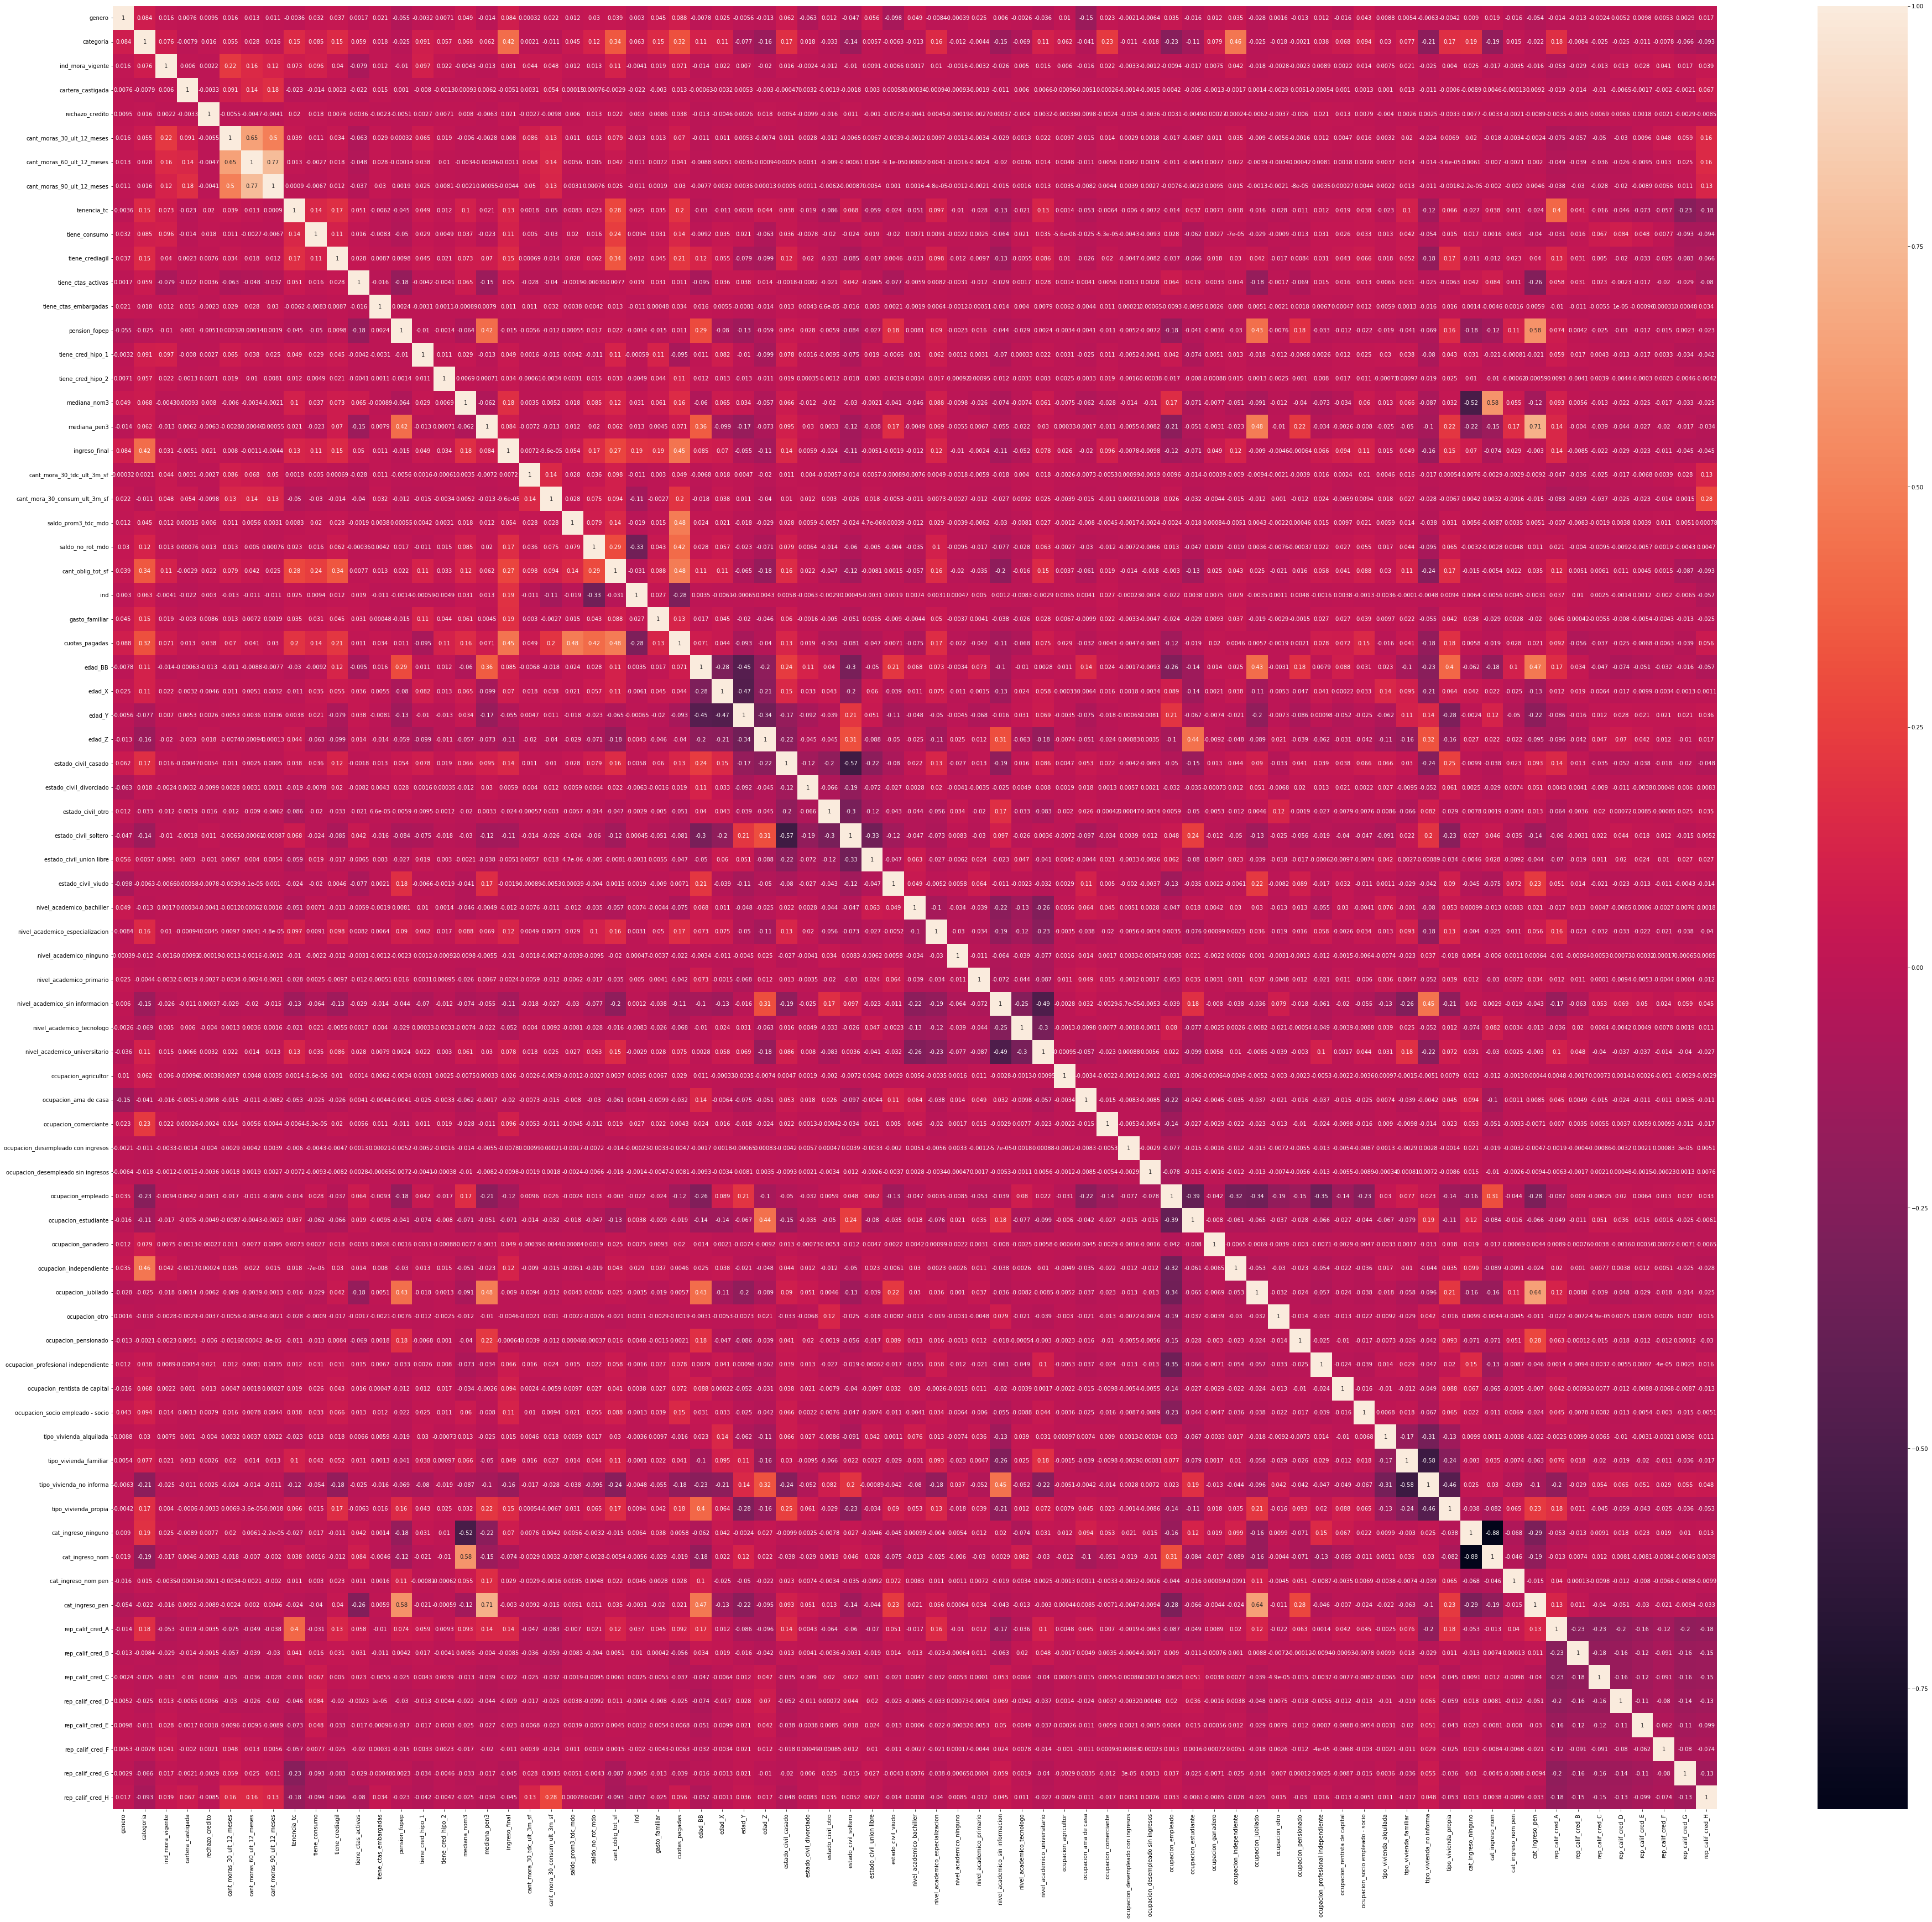

In [18]:
plt.figure(figsize = (65,60))
corrMatrix = cat_df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

## Modelo

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error

In [43]:
cat_df = cat_df.fillna(0)

In [21]:
#X = cat_df.drop(["gasto_familiar"], axis = 1)
#Y = cat_df["gasto_familiar"]

In [22]:
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

In [23]:
#model = RandomForestRegressor(max_depth = 30, n_estimators=200, verbose = 2)
#model.fit(X_train, y_train)

In [24]:
#y_pred = model.predict(X_test)

In [25]:
#mape = mean_absolute_percentage_error(y_test, y_pred)
#print(f"El MAPE es :{mape}")

In [26]:
#importances = model.feature_importances_
#std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

In [27]:
#feature_names = list(cat_df.columns)
#feature_names.index("gasto_familiar")
#del feature_names[25]

In [28]:
#forest_importances = pd.Series(importances, index=feature_names)

#fig, ax = plt.subplots()
#fig.set_figheight(15)
#fig.set_figwidth(10)

#forest_importances.plot.bar(yerr=std, ax=ax)
#ax.set_title("Feature importances using MDI")
#ax.set_ylabel("Mean decrease in impurity")
#fig.tight_layout()

In [29]:
cat_df.describe()
cat_df.to_csv("data_clean.csv", index = False,)

,genero,categoria,ind_mora_vigente,cartera_castigada,rechazo_credito,cant_moras_30_ult_12_meses,cant_moras_60_ult_12_meses,cant_moras_90_ult_12_meses,tenencia_tc,tiene_consumo,...,cat_ingreso_nom pen,cat_ingreso_pen,rep_calif_cred_A,rep_calif_cred_B,rep_calif_cred_C,rep_calif_cred_D,rep_calif_cred_E,rep_calif_cred_F,rep_calif_cred_G,rep_calif_cred_H
count,475978.000000,475978.000000,475978.000000,475978.000000,475978.000000,475978.000000,475978.000000,475978.000000,475978.000000,475978.000000,...,475978.000000,475978.000000,475978.000000,475978.000000,475978.000000,475978.000000,475978.000000,475978.000000,475978.000000,475978.000000
mean,0.496252,1.507620,0.025997,0.001878,0.005622,0.021942,0.009311,0.005519,0.418070,0.138616,...,0.003536,0.060230,0.225479,0.152511,0.152667,0.121945,0.076709,0.044330,0.121165,0.105194
std,0.499986,0.800887,0.159126,0.043298,0.074770,0.146495,0.096045,0.074086,0.493242,0.345545,...,0.059358,0.237912,0.417898,0.359516,0.359666,0.327222,0.266130,0.205827,0.326320,0.306803
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [44]:
max_val = cat_df.gasto_familiar.quantile(0.95)
min_val = cat_df.gasto_familiar.quantile(0.05)

In [45]:
cat_df = cat_df[(cat_df['gasto_familiar'] > min_val) & (cat_df['gasto_familiar']< max_val)]

In [46]:
X_2 = cat_df.drop(["gasto_familiar"], axis = 1)
Y_2 = cat_df["gasto_familiar"]

In [47]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X_2, Y_2, test_size=0.3)

In [34]:
#model2 = RandomForestRegressor(max_depth = 30, n_estimators=200, verbose = 2)
#model2.fit(X2_train, y2_train)

In [35]:
#y2_pred = model.predict(X2_test)
#mape = mean_absolute_percentage_error(y2_test, y2_pred)
#print(f"El MAPE es :{mape}")

In [48]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2, verbose=True))
regr.fit(X2_train, y2_train)

[LibSVM]..................................................................................................................................................
*
optimization finished, #iter = 146642
obj = -85770683912.587814, rho = -433126.055469
nSV = 266416, nBSV = 266416


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(epsilon=0.2, verbose=True))])

In [49]:
y2_pred = regr.predict(X2_test)
mape = mean_absolute_percentage_error(y2_test, y2_pred)
print(f"El MAPE es :{mape}")

El MAPE es :0.9175701730588178
